# <center> Can we detect fraudulent transactions using ML? </center>

<div style="text-align: justify"> The data for this notebook has been procured from the following <a href = "https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset" target="_blank">Kaggle</a> </div> 

Online banking has now become the norm as customers are moving towards easier and more efficient methods for banking. However, this leaves some individuals vulnerable to scams and fraudulent transactions. 
<br> The aim of this notebook is to find out whether fraudulent transactions can be predicted with any degree of accuracy. This may be the norm moving forwards and could be implemented into onlie banking systems to stop these transactions before they happen.

Column references: (taken from the Kaggle)

* step: represents a unit of time where 1 step equals 1 hour
* type: type of online transaction
* amount: the amount of the transaction
* nameOrig: customer starting the transaction
* oldbalanceOrg: balance before the transaction
* newbalanceOrig: balance after the transaction
* nameDest: recipient of the transaction
* oldbalanceDest: initial balance of recipient before the transaction
* newbalanceDest: the new balance of recipient after the transaction
* isFraud: fraud transaction

This notebook displays the following: 
* Data loading 
* Exploratory data analysis 
* Data cleaning and pre-processing
* Model building 
* Measuring the accuracy of our models 

## <center> Data loading </center>

### Data loading 

In [4]:
## import the necessary libaries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve


In [5]:
# loading the data 
data = pd.read_csv("Fraud_detection.csv")

In [6]:
## what does our dataset look like?
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
data.shape

(6362620, 11)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## <center> Exploratory data analysis  </center>

are origin ID and dest ID same? can help with is fraudulent or not? 

In [9]:
""" #What type of the transactions were fraudulent/not fraudulent?
colour = ["#4b6043", "#c7ddb5"]
sns.countplot(x="type", hue="isFraud", data=data, palette=colour) """

' #What type of the transactions were fraudulent/not fraudulent?\ncolour = ["#4b6043", "#c7ddb5"]\nsns.countplot(x="type", hue="isFraud", data=data, palette=colour) '

In [10]:
## visualisiations

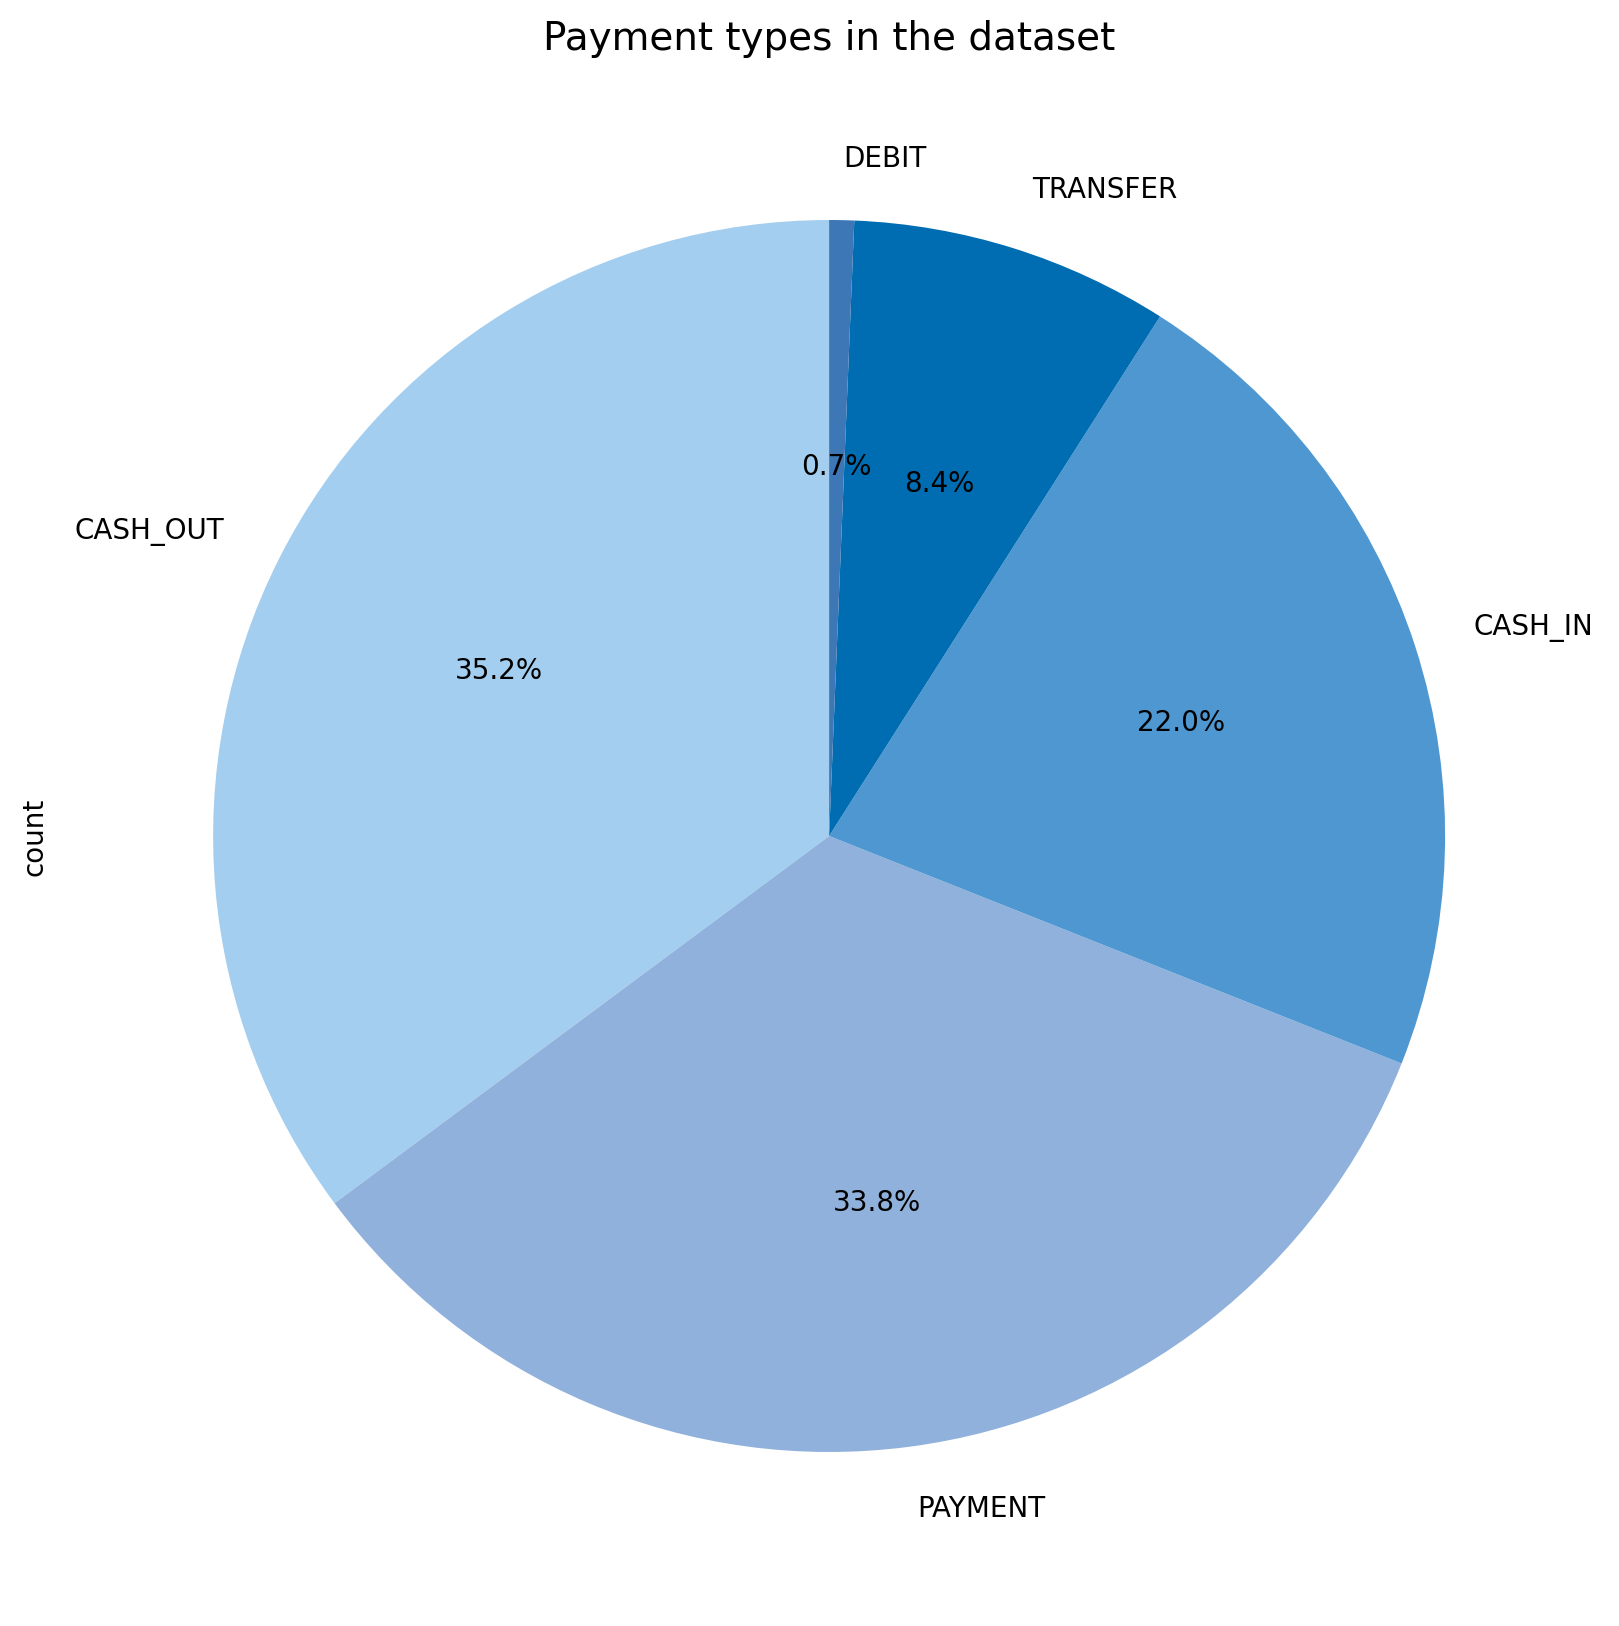

In [11]:
## types and how many of each 
pie = data["type"].value_counts()
colours = ["#A3CEEF", "#90B1DB", "#4E97D1", "#006DB2", "#3E77B6", "#6C85BD", "#C5D4EB", "#DFE9F5"]
pie2 = pie.plot.pie(figsize = (10,10), colors = colours, autopct="%1.1f%%", startangle=90)
plt.title("Payment types in the dataset", fontsize = 14)

%config InlineBackend.figure_format='retina'

<Axes: xlabel='isFraud', ylabel='count'>

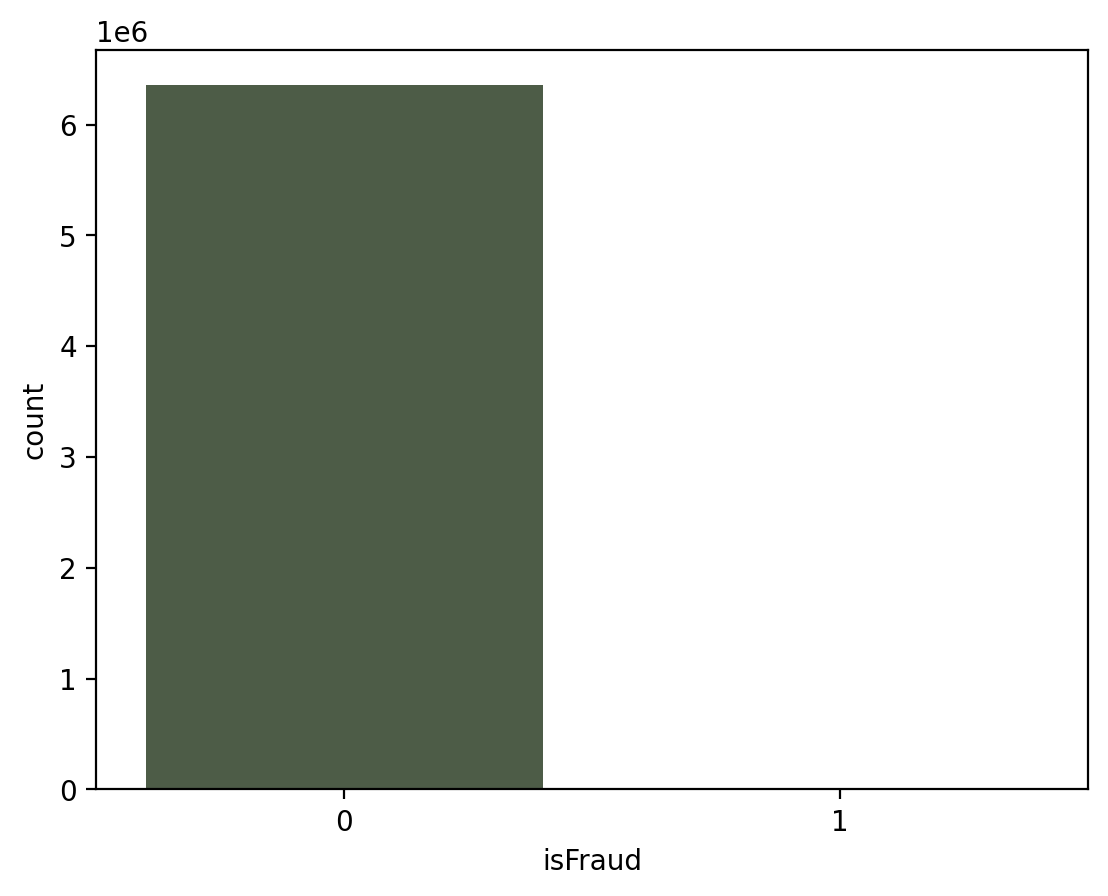

In [12]:
## fraud or not fraud 
colour = ["#4b6043", "#c7ddb5"]
sns.countplot(x= data["isFraud"], palette=colour)


<Axes: >

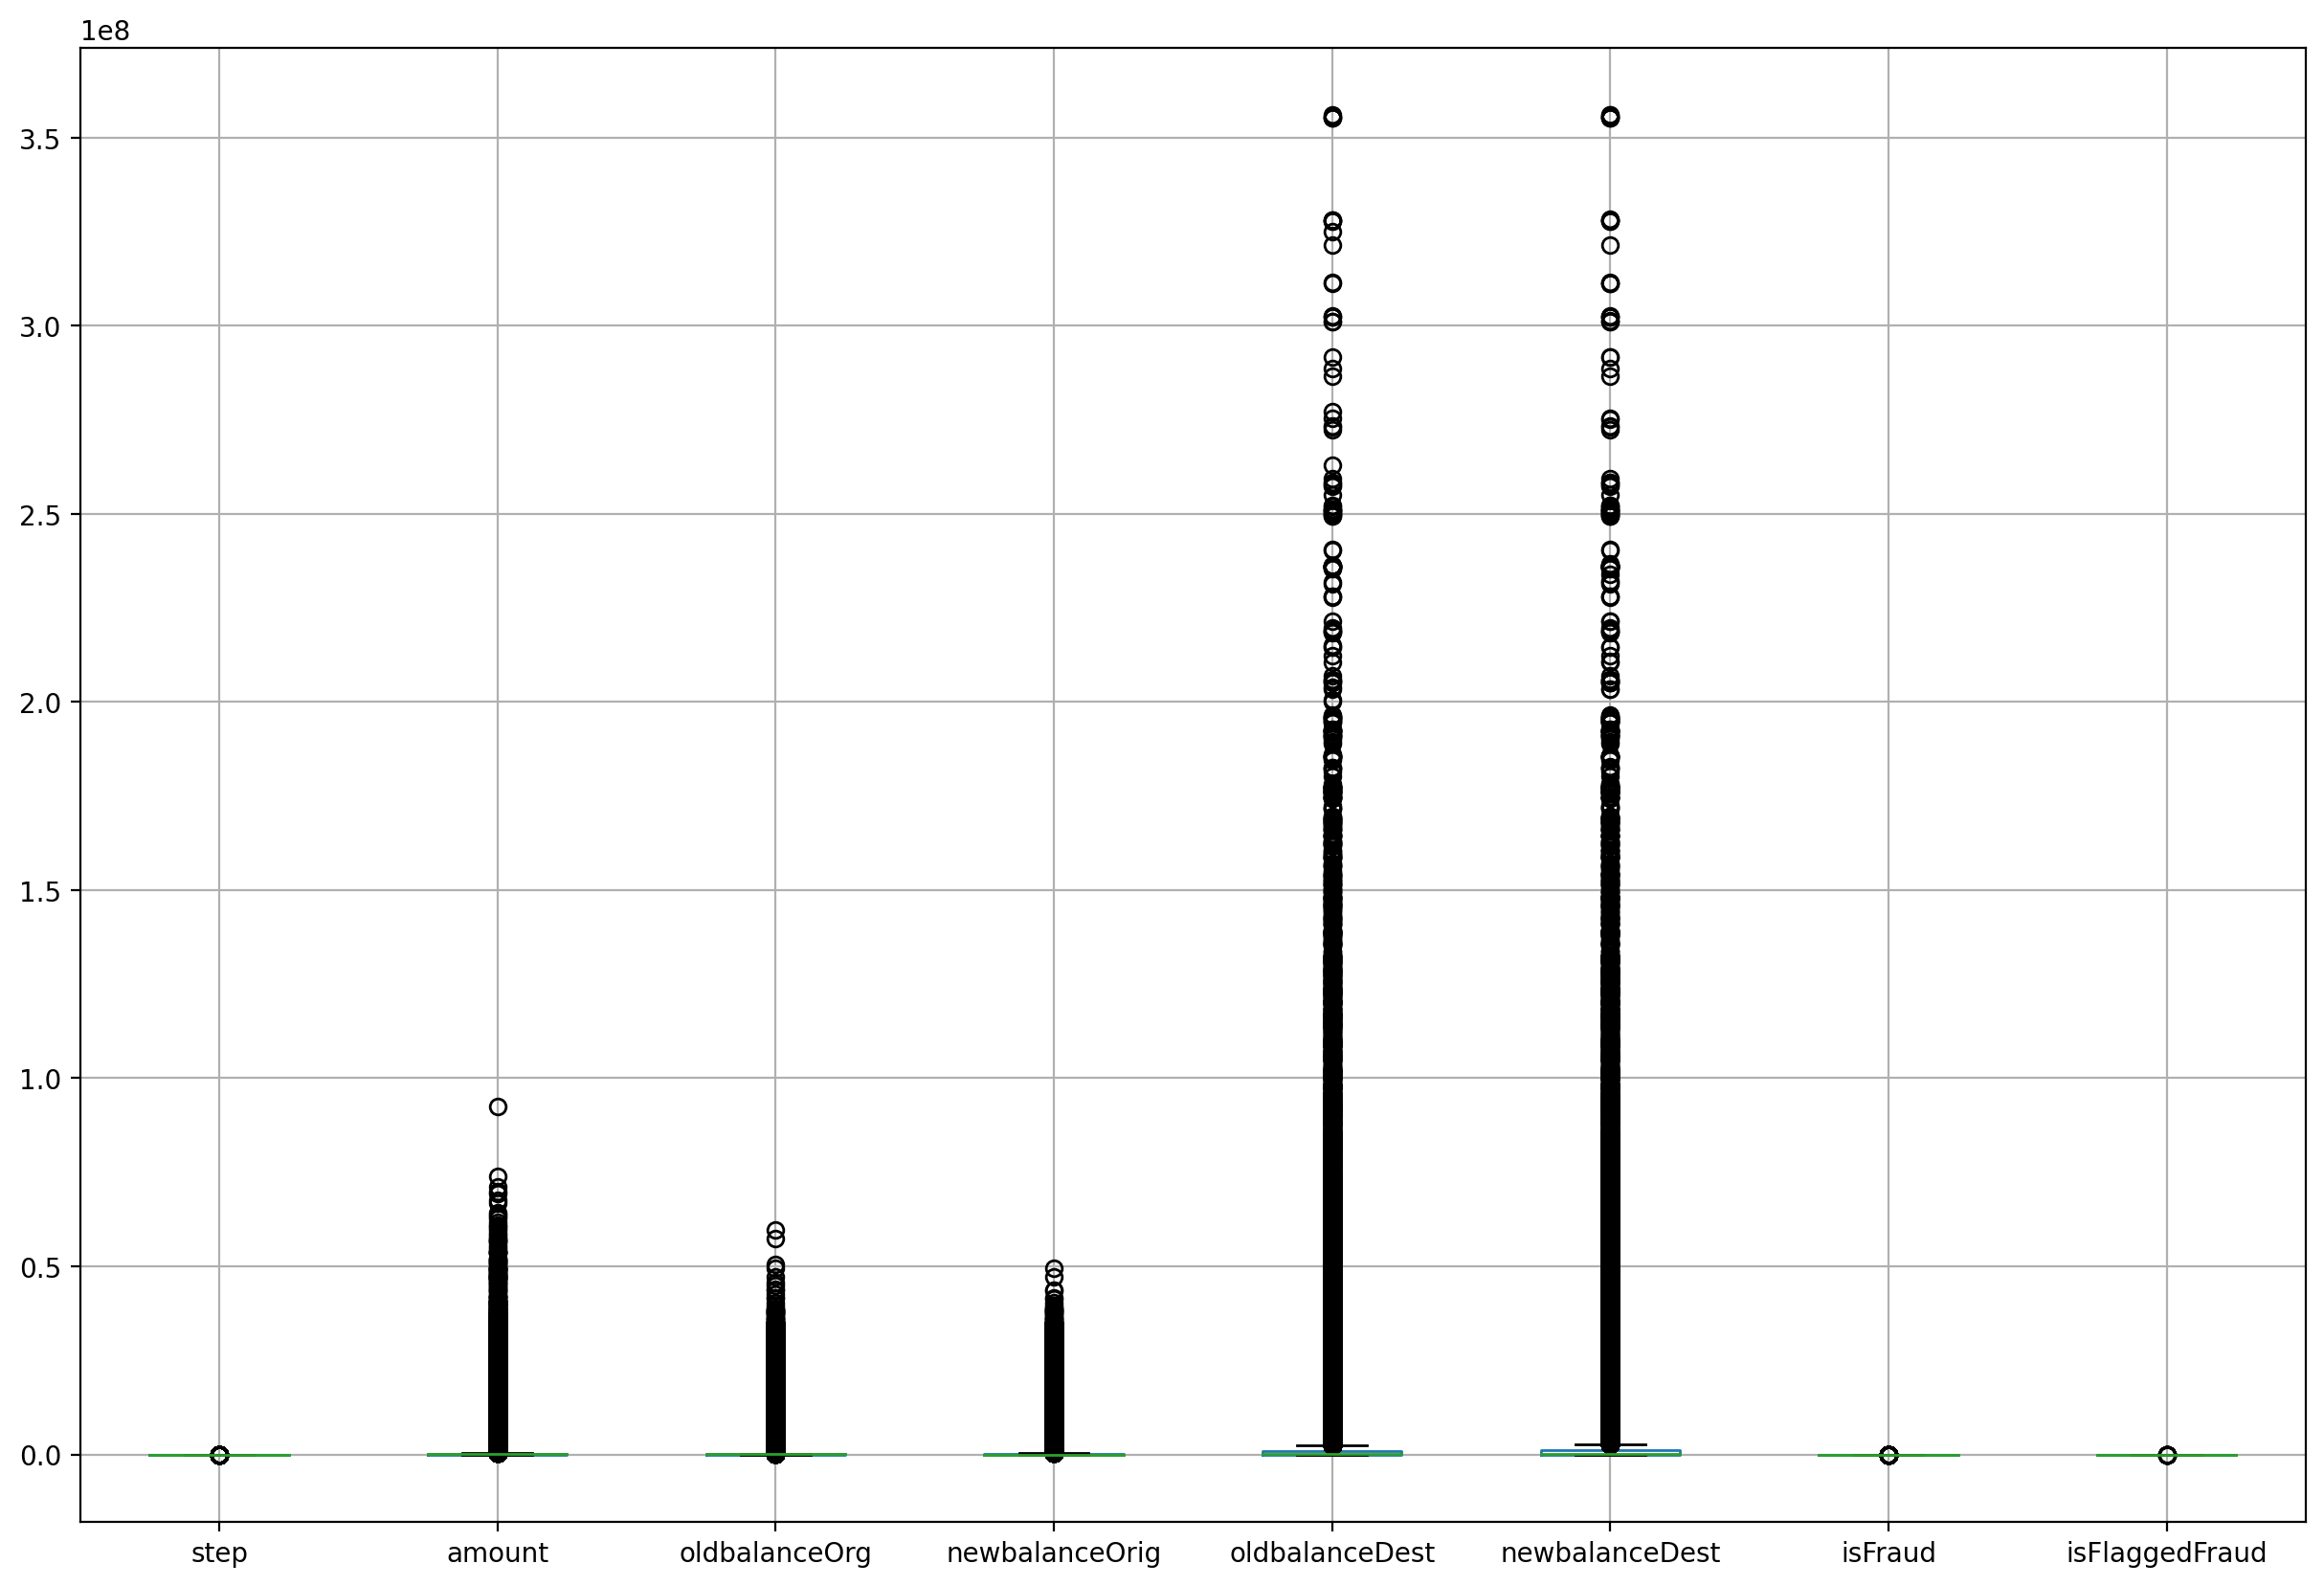

In [13]:
data.boxplot(figsize = (15,10))

In [14]:
""" columns = data.iloc[:]
# Iterate over each column and remove outliers
for column in columns:
    max_threshold, min_threshold = data[column].quantile([0.75, 0.25])
    new_df = data[(data[column] > min_threshold) & (data[column] < max_threshold)]
    # Update the original DataFrame with the new values
    data = new_df.copy()
# Print the updated DataFrame
print(data) """ 

' columns = data.iloc[:]\n# Iterate over each column and remove outliers\nfor column in columns:\n    max_threshold, min_threshold = data[column].quantile([0.75, 0.25])\n    new_df = data[(data[column] > min_threshold) & (data[column] < max_threshold)]\n    # Update the original DataFrame with the new values\n    data = new_df.copy()\n# Print the updated DataFrame\nprint(data) '

In [15]:
## what is the correlation between the variables and the transaction being fraudulent?
corr = data.corr(numeric_only=True)
corr

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


In [16]:
## Making it easier to see how all the features correlate with fraud
corr["isFraud"].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

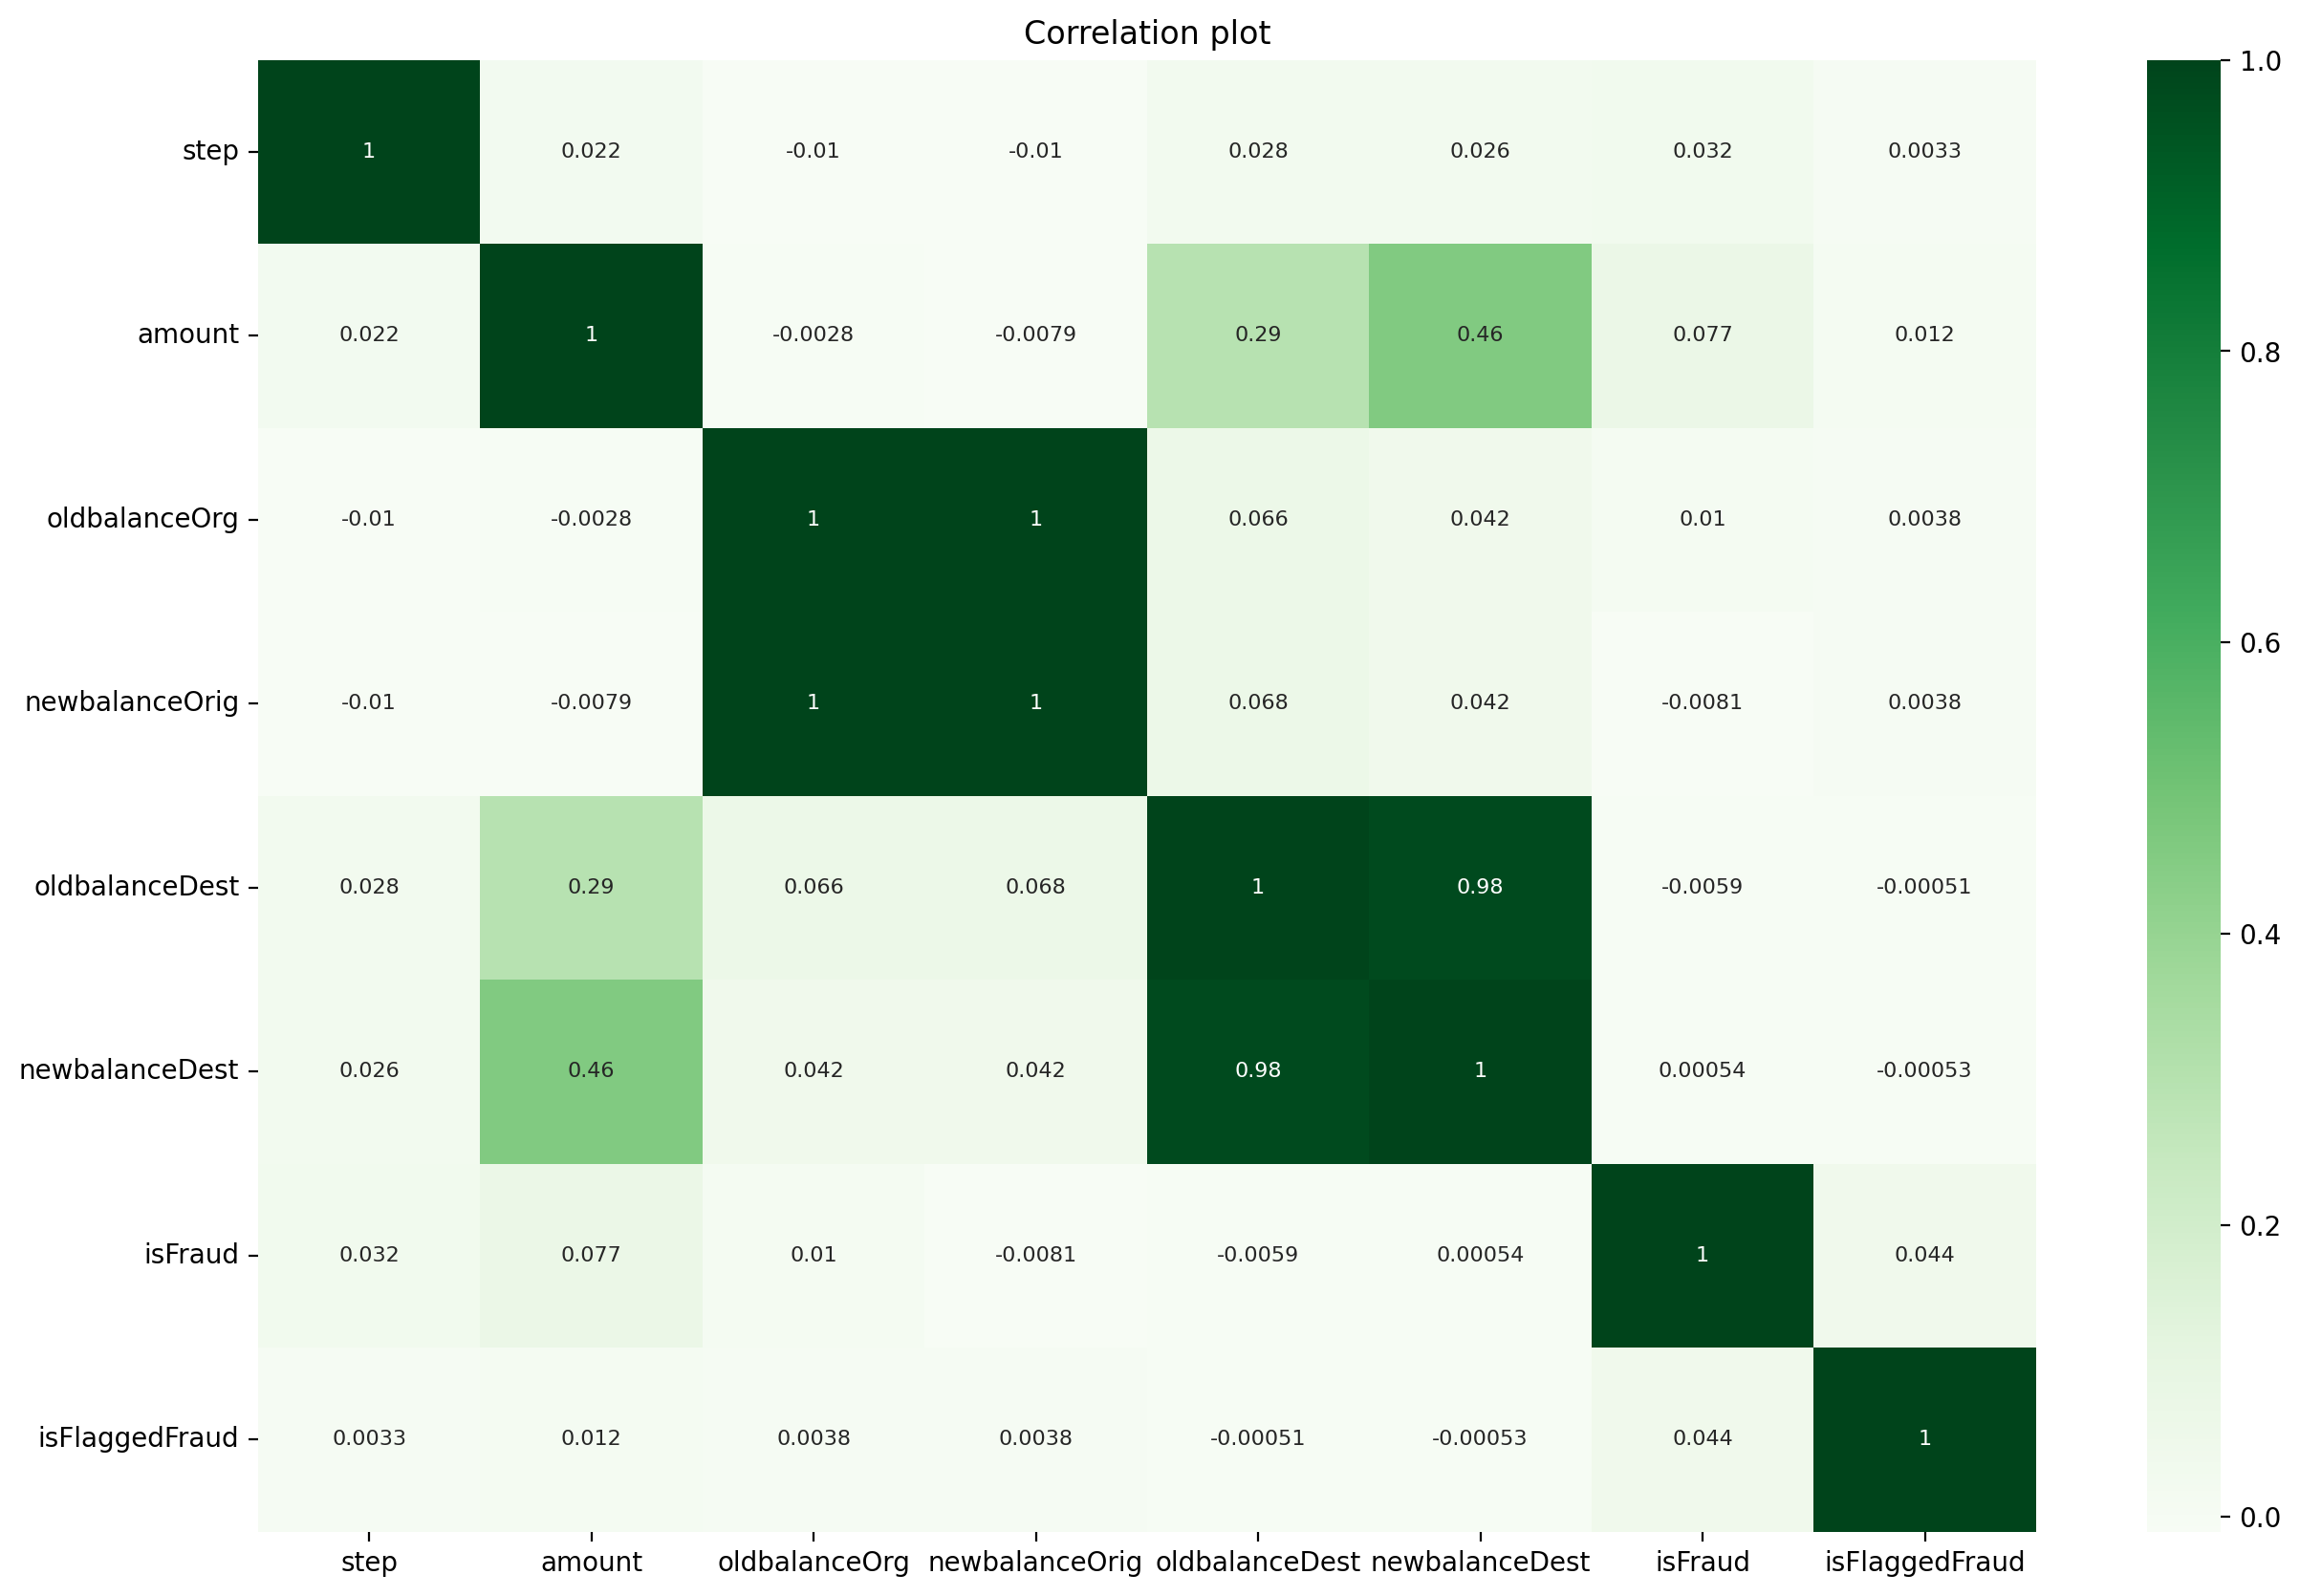

In [17]:
## heatmap 
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot= True, cmap= "Greens", annot_kws={"size" : 8}) 
plt.title('Correlation plot', loc = "center")
plt.show()
%config InlineBackend.figure_format='retina'

## <center> Data cleaning and pre-processing </center>

Trying to ascertain answers to the following questions:
<br>Are there null values?
<br>Do the datatypes of any columns need changing? 
<br>Do any of the columns need dropping?
<br>Are there any duplicated rows?
<br>Do columns need encoding? 
<br>Are there any duplicated rows?
<br>Are there outliers? Do they need to be removed?
<br> What kind of preprocessing needs to be done to the data for ML? 
    <br> - Does it need to be scaled/normalised? 
    <br> - Is the dataset imbalanced?
    <br> - How will the features be chosen?
    <br> - Do any of the columns need encoding?
    <br> - What is the skew of the data? 

In [18]:
## are there any null values?
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [19]:
## are there any duplicated rows?
data.duplicated().keep=False

In [20]:
## can the type column be encoded? yes it needs one hot encoding
data["type"].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [21]:
## one hot encoding type column 
from sklearn.preprocessing import OneHotEncoder 
onehotencoder = OneHotEncoder()
# convert column to category 
data["type"] = data["type"].astype("category")
data["type_new"]= data["type"].cat.codes
onehotencoder_data = pd.DataFrame(onehotencoder.fit_transform(data[["type_new"]]).toarray())
new_data = data.join(onehotencoder_data)
## drop the type column 
new_data = new_data.drop(["type"], axis = 1)

In [22]:
## payment = 3 
## transfer = 4
## cash_out = 1
## debit = 2 
## cash_in = 0

new_data


,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_new,0,1,2,3,4
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,3,0.0,0.0,0.0,1.0,0.0
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,3,0.0,0.0,0.0,1.0,0.0
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,4,0.0,0.0,0.0,0.0,1.0
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,1,0.0,1.0,0.0,0.0,0.0
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,3,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,1,0.0,1.0,0.0,0.0,0.0
6362616,743,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,4,0.0,0.0,0.0,0.0,1.0
6362617,743,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,1,0.0,1.0,0.0,0.0,0.0
6362618,743,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,4,0.0,0.0,0.0,0.0,1.0


In [23]:
#is the data balanced?
data["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [24]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_new
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06,1.714150e+00
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03,1.350117e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00,1.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00,3.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00,4.000000e+00


<function matplotlib.pyplot.show(close=None, block=None)>

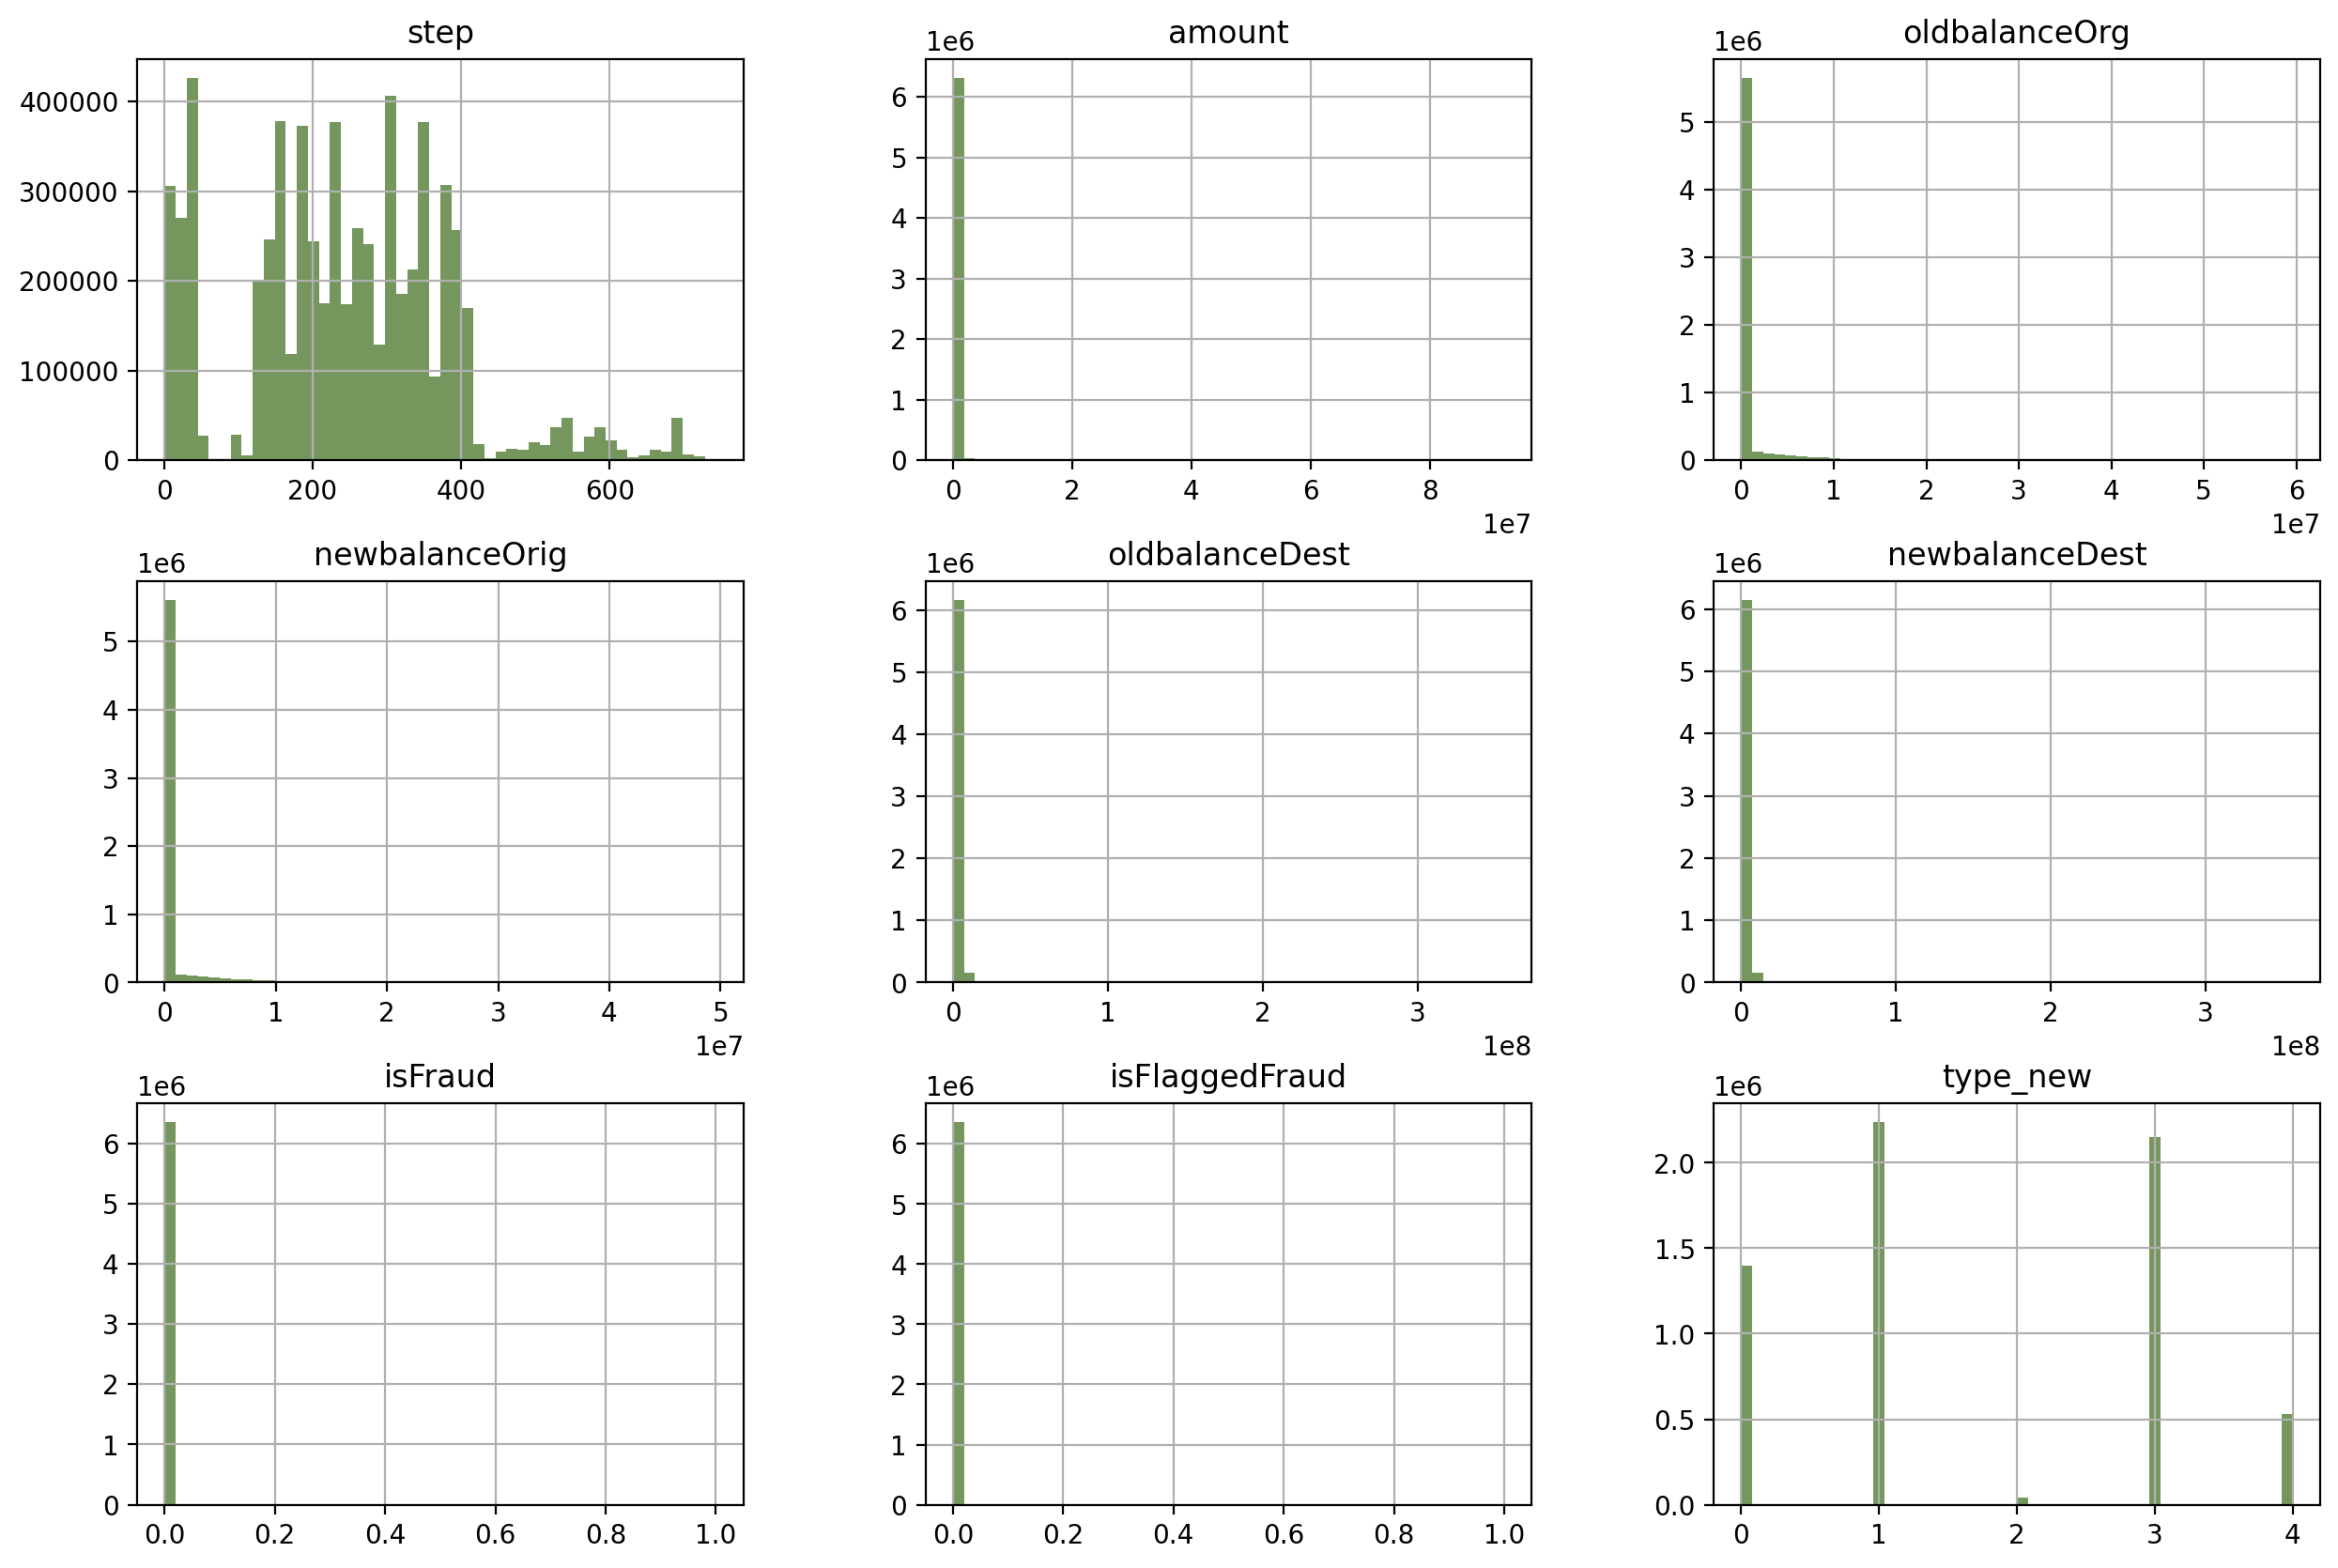

In [25]:
## what is the skew of the data?
data.hist(bins=50, figsize=(15, 10), color = "#75975e")
plt.show

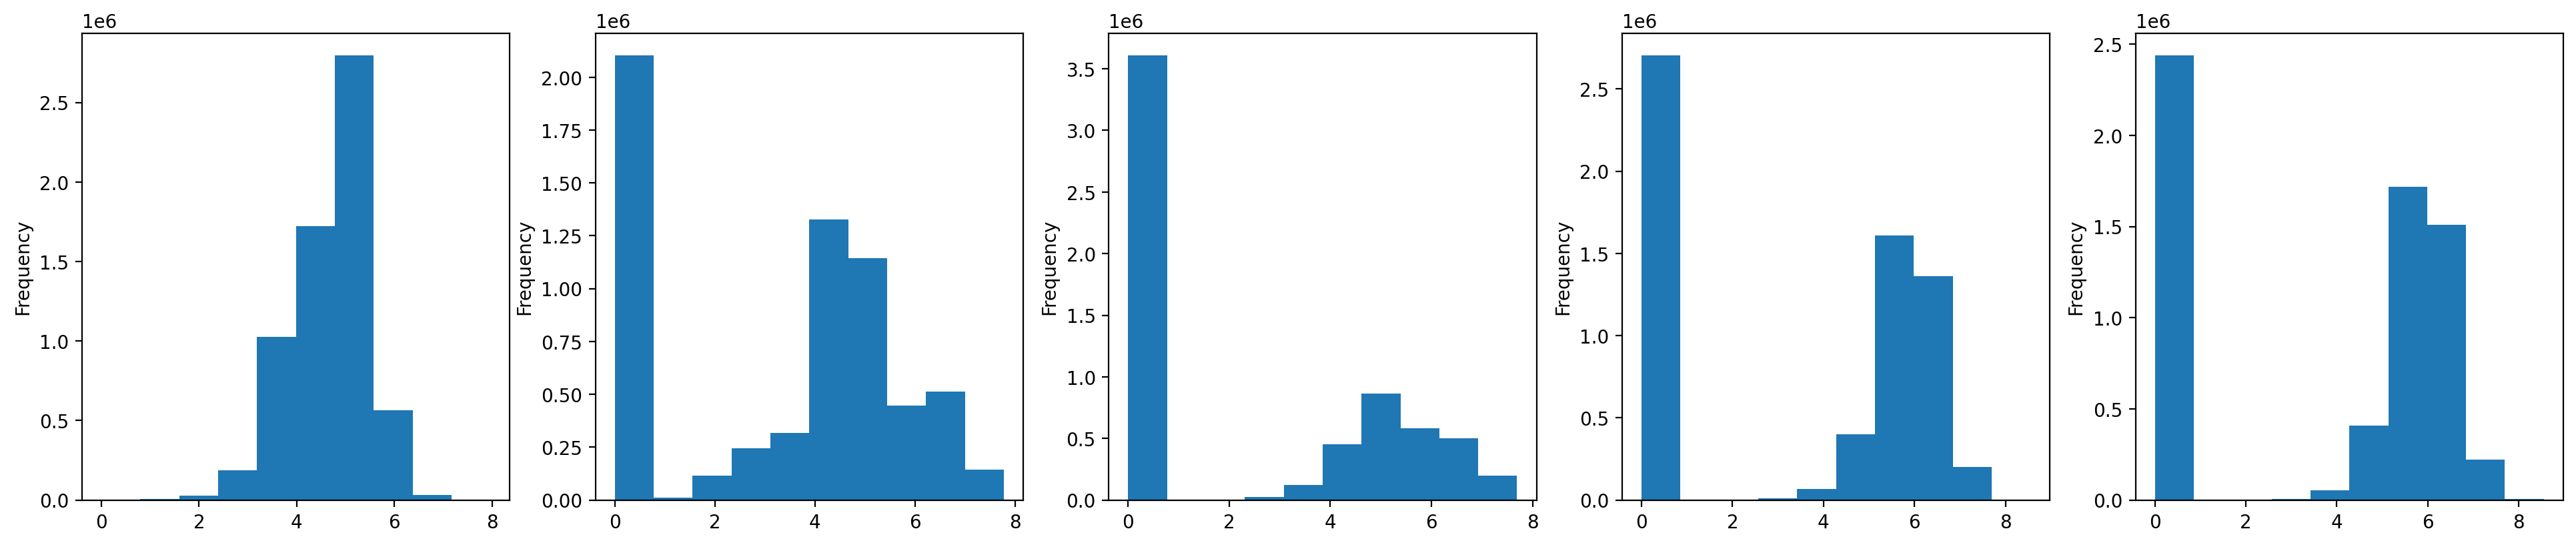

In [26]:
log_var = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]

fig = plt.figure(figsize = (24, 10))
for j in range (len (log_var)):
    var = log_var[j]
    transformed = "log_" + var
    new_data[transformed] = np.log10(new_data [var]+1)
    sub = fig.add_subplot(2, 5, j + 1)
    sub.set_xlabel (var)
    new_data[transformed].plot(kind = 'hist')

In [27]:
new_data 

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,...,0,1,2,3,4,log_amount,log_oldbalanceOrg,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,...,0.0,0.0,0.0,1.0,0.0,3.993023,5.230799,5.204926,0.000000,0.000000
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,...,0.0,0.0,0.0,1.0,0.0,3.270744,4.327359,4.287482,0.000000,0.000000
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,...,0.0,0.0,0.0,0.0,1.0,2.260071,2.260071,0.000000,0.000000,0.000000
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,...,0.0,1.0,0.0,0.0,0.0,2.260071,2.260071,0.000000,4.325987,0.000000
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,...,0.0,0.0,0.0,1.0,0.0,4.067039,4.618623,4.475480,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,...,0.0,1.0,0.0,0.0,0.0,5.531074,5.531074,0.000000,0.000000,5.531074
6362616,743,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,...,0.0,0.0,0.0,0.0,1.0,6.800126,6.800126,0.000000,0.000000,0.000000
6362617,743,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,...,0.0,1.0,0.0,0.0,0.0,6.800126,6.800126,0.000000,4.835626,6.804814
6362618,743,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,...,0.0,0.0,0.0,0.0,1.0,5.929421,5.929421,0.000000,0.000000,0.000000


array([[<Axes: title={'center': 'step'}>,
        <Axes: title={'center': 'amount'}>,
        <Axes: title={'center': 'oldbalanceOrg'}>,
        <Axes: title={'center': 'newbalanceOrig'}>],
       [<Axes: title={'center': 'oldbalanceDest'}>,
        <Axes: title={'center': 'newbalanceDest'}>,
        <Axes: title={'center': 'isFraud'}>,
        <Axes: title={'center': 'isFlaggedFraud'}>],
       [<Axes: title={'center': 'type_new'}>,
        <Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>,
        <Axes: title={'center': 'log_amount'}>,
        <Axes: title={'center': 'log_oldbalanceOrg'}>],
       [<Axes: title={'center': 'log_newbalanceOrig'}>,
        <Axes: title={'center': 'log_oldbalanceDest'}>,
        <Axes: title={'center': 'log_newbalanceDest'}>, <Axes: >]],
      dtype=object)

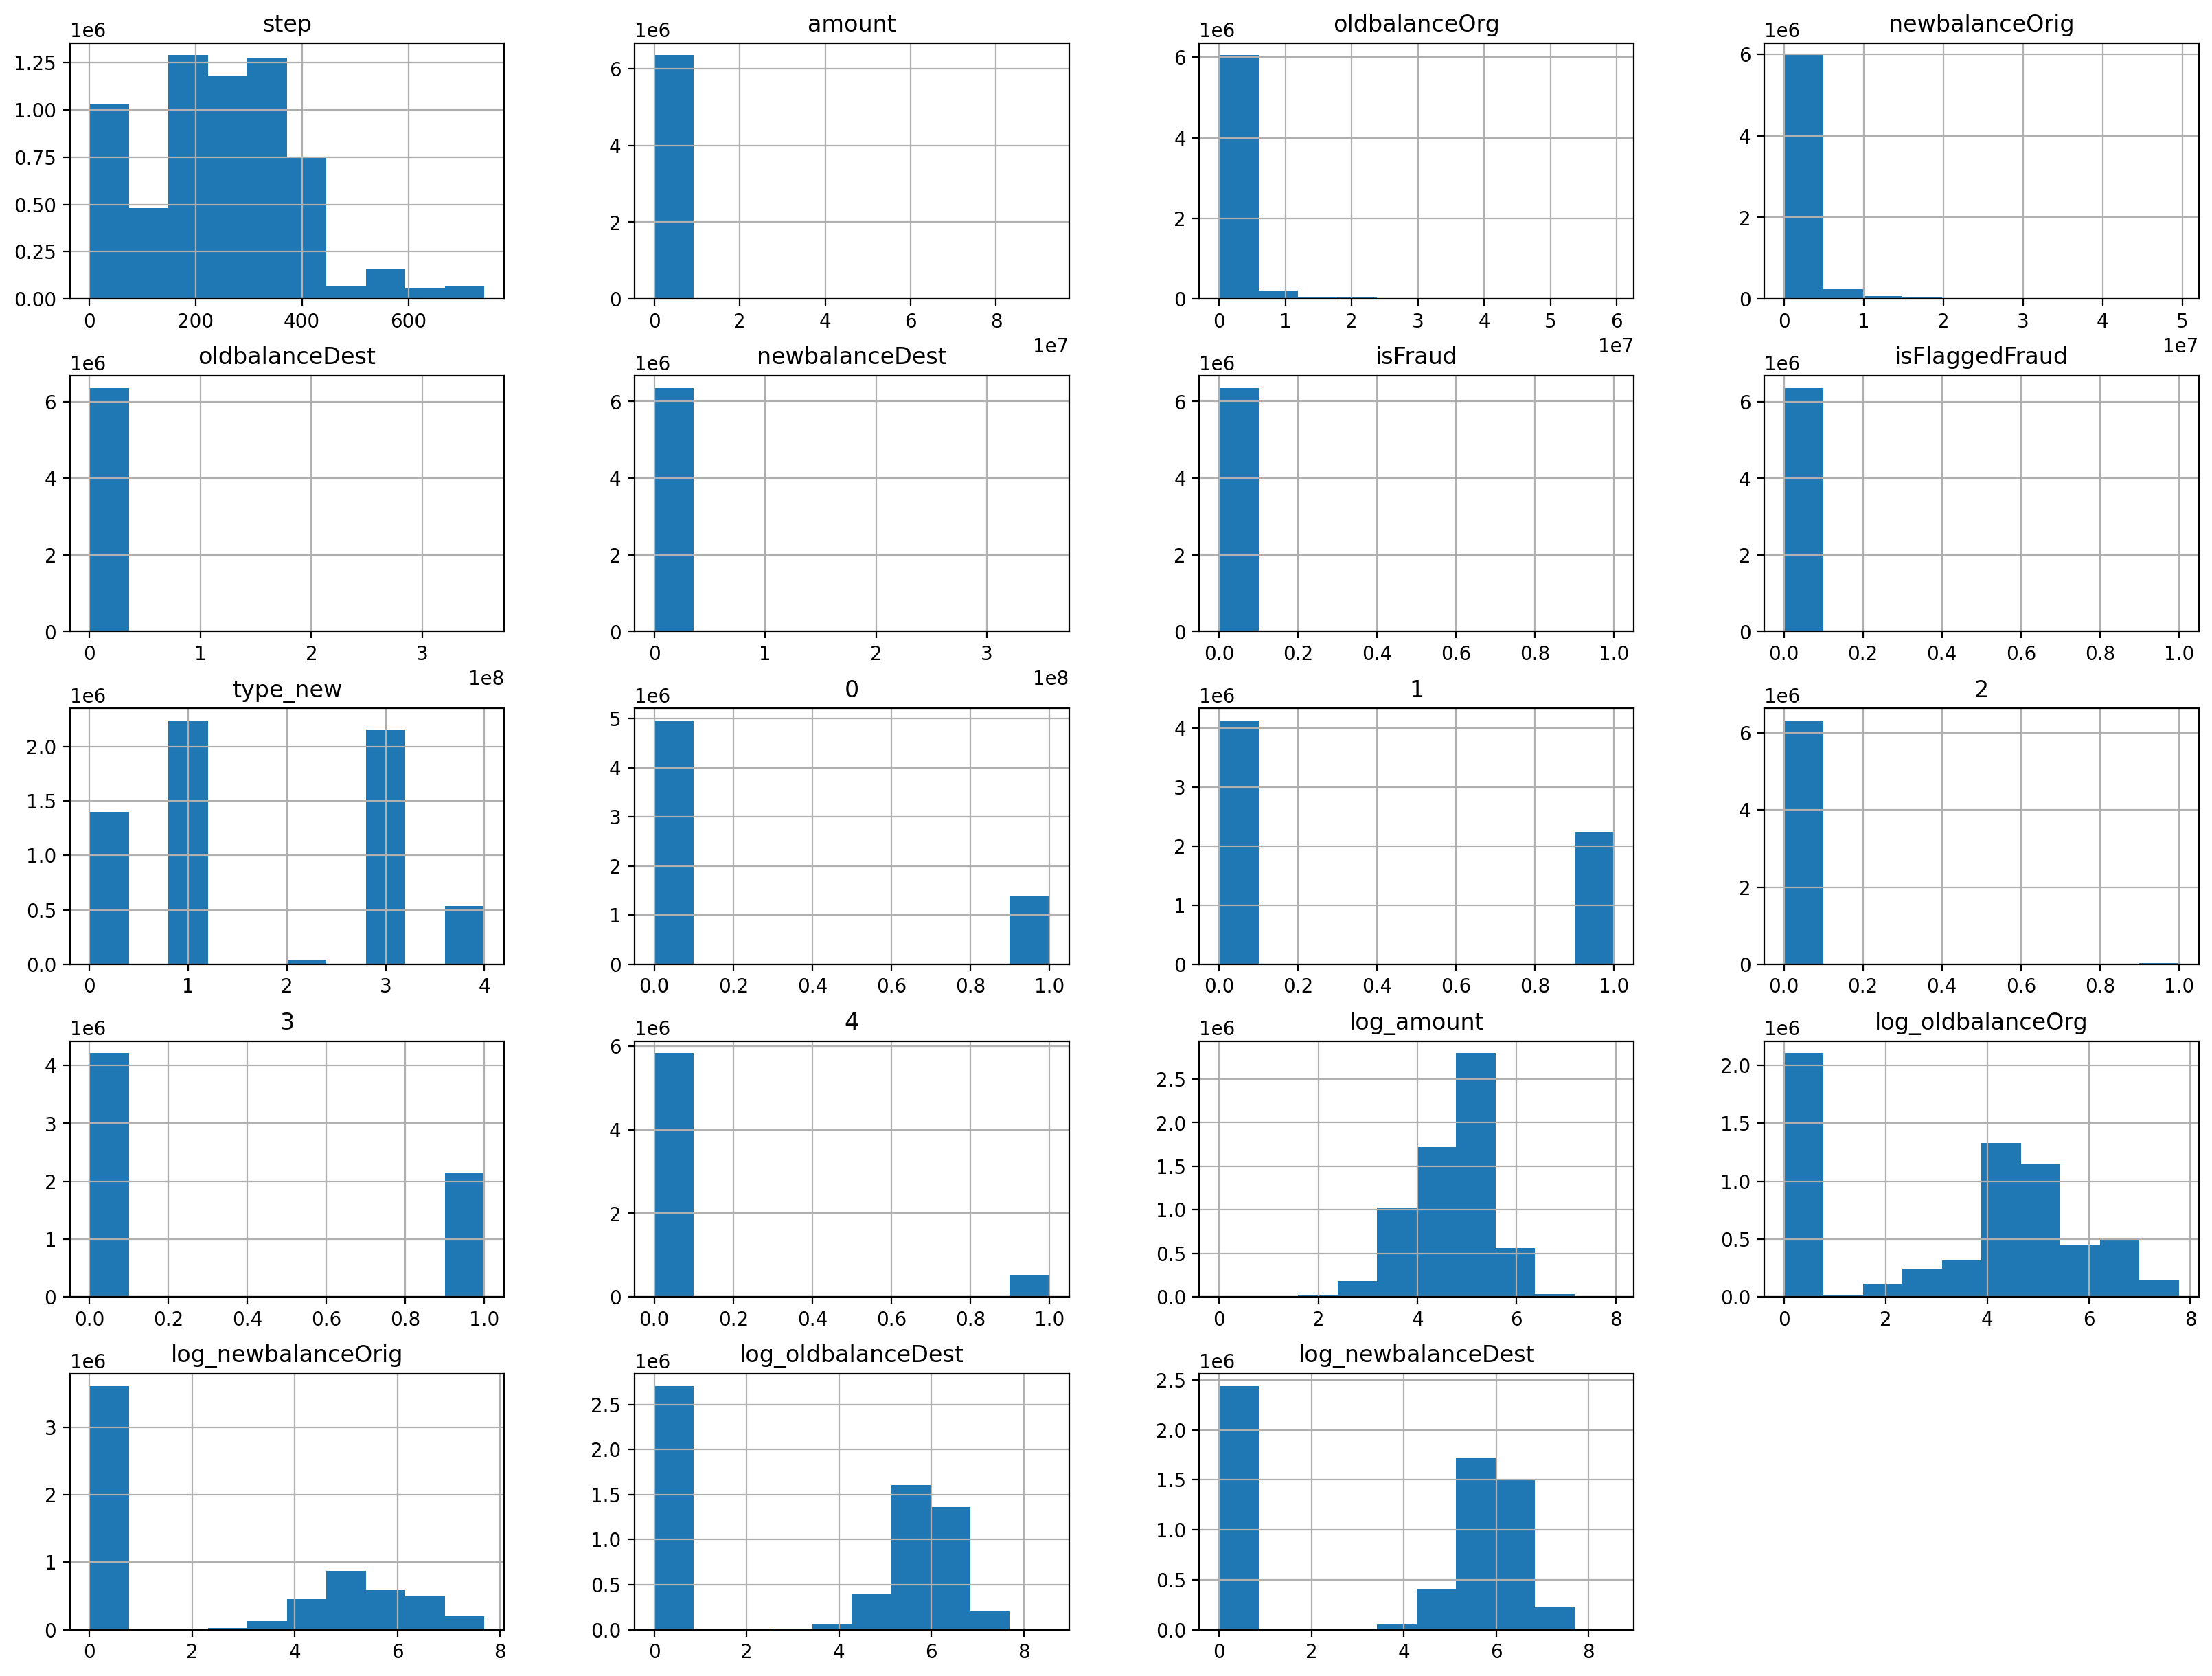

In [28]:
new_data.hist(figsize = (20,15))

In [29]:
""" clip_var = ["oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for i in clip_var:
    transformed = "clipped_" + i
    # upper limit - .75 quantile
    upper_limit = new_data[i].quantile(0.75)
    ## lower limit - .25 quantile 
    lower_limit = new_data[i].quantile(0.25)
    new_data [transformed] = new_data[i].clip(lower_limit, upper_limit, axis=0)
    
    print(new_data[i].describe())
    print(new_data[transformed].describe()) """ 


' clip_var = ["oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]\nfor i in clip_var:\n    transformed = "clipped_" + i\n    # upper limit - .75 quantile\n    upper_limit = new_data[i].quantile(0.75)\n    ## lower limit - .25 quantile \n    lower_limit = new_data[i].quantile(0.25)\n    new_data [transformed] = new_data[i].clip(lower_limit, upper_limit, axis=0)\n    \n    print(new_data[i].describe())\n    print(new_data[transformed].describe()) '

In [30]:
# new_data.head()

In [31]:
corr_new = new_data.corr()

ValueError: could not convert string to float: 'C1231006815'

## <center> Model building </center>

In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 21 columns):
 #   Column              Dtype  
---  ------              -----  
 0   step                int64  
 1   amount              float64
 2   nameOrig            object 
 3   oldbalanceOrg       float64
 4   newbalanceOrig      float64
 5   nameDest            object 
 6   oldbalanceDest      float64
 7   newbalanceDest      float64
 8   isFraud             int64  
 9   isFlaggedFraud      int64  
 10  type_new            int8   
 11  0                   float64
 12  1                   float64
 13  2                   float64
 14  3                   float64
 15  4                   float64
 16  log_amount          float64
 17  log_oldbalanceOrg   float64
 18  log_newbalanceOrig  float64
 19  log_oldbalanceDest  float64
 20  log_newbalanceDest  float64
dtypes: float64(15), int64(3), int8(1), object(2)
memory usage: 976.9+ MB


In [ ]:
## selecting the independant and dependant variable 
## no step?
dep = data["isFraud"]
x = data.iloc[:, 10:21].values
y = dep.values

In [ ]:
y

array([0, 0, 1, ..., 1, 1, 1])

[Text(0.5, 1.0, 'Proportion of fraudulent transactions after oversampling ')]

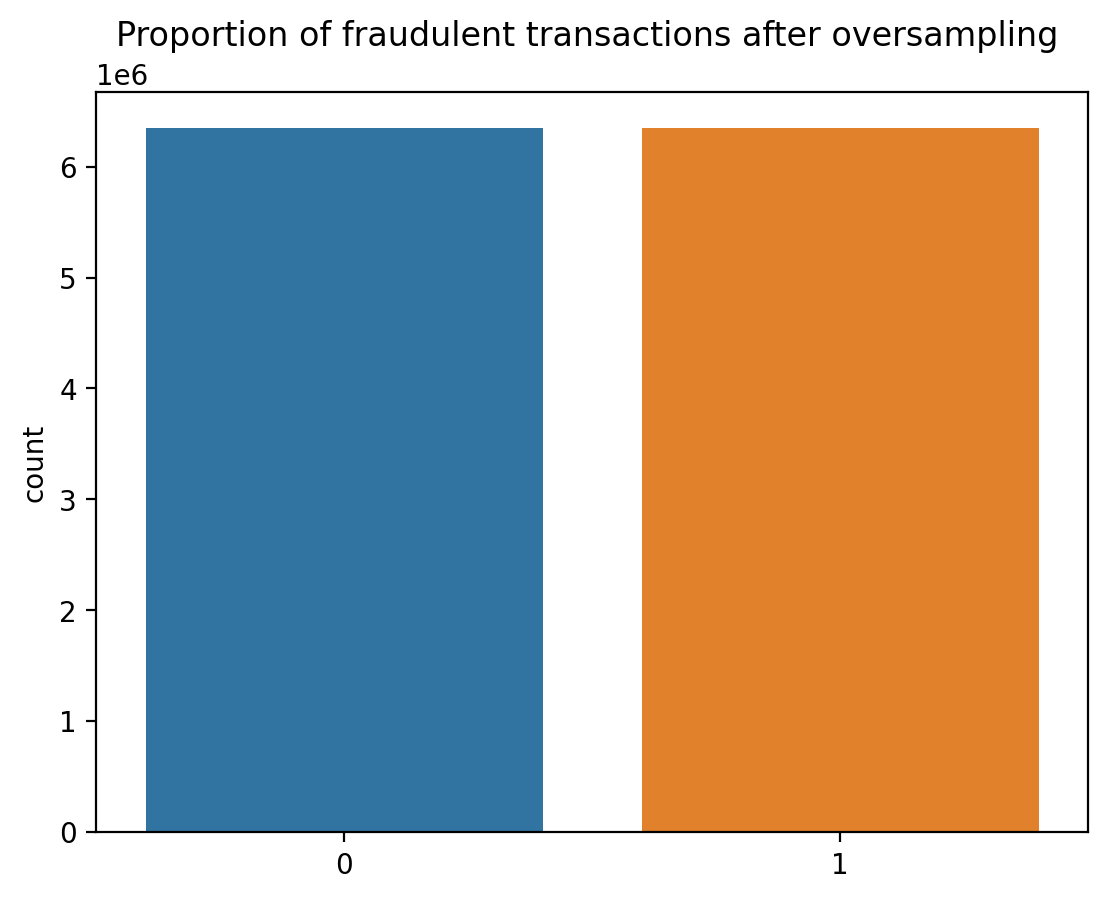

In [ ]:
## imbalanced data 
## trying oversampling first 
## SMOTE
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

## Proportion of fraudulent transactions
sns.countplot(x=y).set(title='Proportion of fraudulent transactions after oversampling ')

In [ ]:
## easy ensemble
#from imblearn.ensemble import EasyEnsembleClassifier

In [ ]:
## split the data into training and testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state = 32)

In [ ]:
## standardisation 
## input data is transformed to have a mean of 0 and variance of 1 
## dont fit x_test only transform so no overfitting 
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

### Logistic Regression

In [ ]:
## logistic regression
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

LogisticRegression()

In [ ]:
## make prediction 
y_pred_log = log_reg.predict(x_test)
y_pred_log

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
## get the result in a dataframe 
result = {"Actual_fraud":y_test, "Predicted_fraud": y_pred_log}
result_df = pd.DataFrame(result)
result_df

,Actual_fraud,Predicted_fraud
0,0,0
1,1,0
2,0,0
3,1,0
4,0,0
...,...,...
2541758,0,0
2541759,1,0
2541760,1,1
2541761,0,0


In [ ]:
## evaluate the model accuracy
accuracy_LR = accuracy_score(y_test, y_pred_log)

## CONFUSION MATRIX
conf_mat = confusion_matrix(y_test, y_pred_log)

print(accuracy_LR)
print(conf_mat)

0.5388917062684444
[[735759 535287]
 [636741 633976]]


In [ ]:
## classification report
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.54      0.58      0.56   1271046
           1       0.54      0.50      0.52   1270717

    accuracy                           0.54   2541763
   macro avg       0.54      0.54      0.54   2541763
weighted avg       0.54      0.54      0.54   2541763



AUC: 0.538887


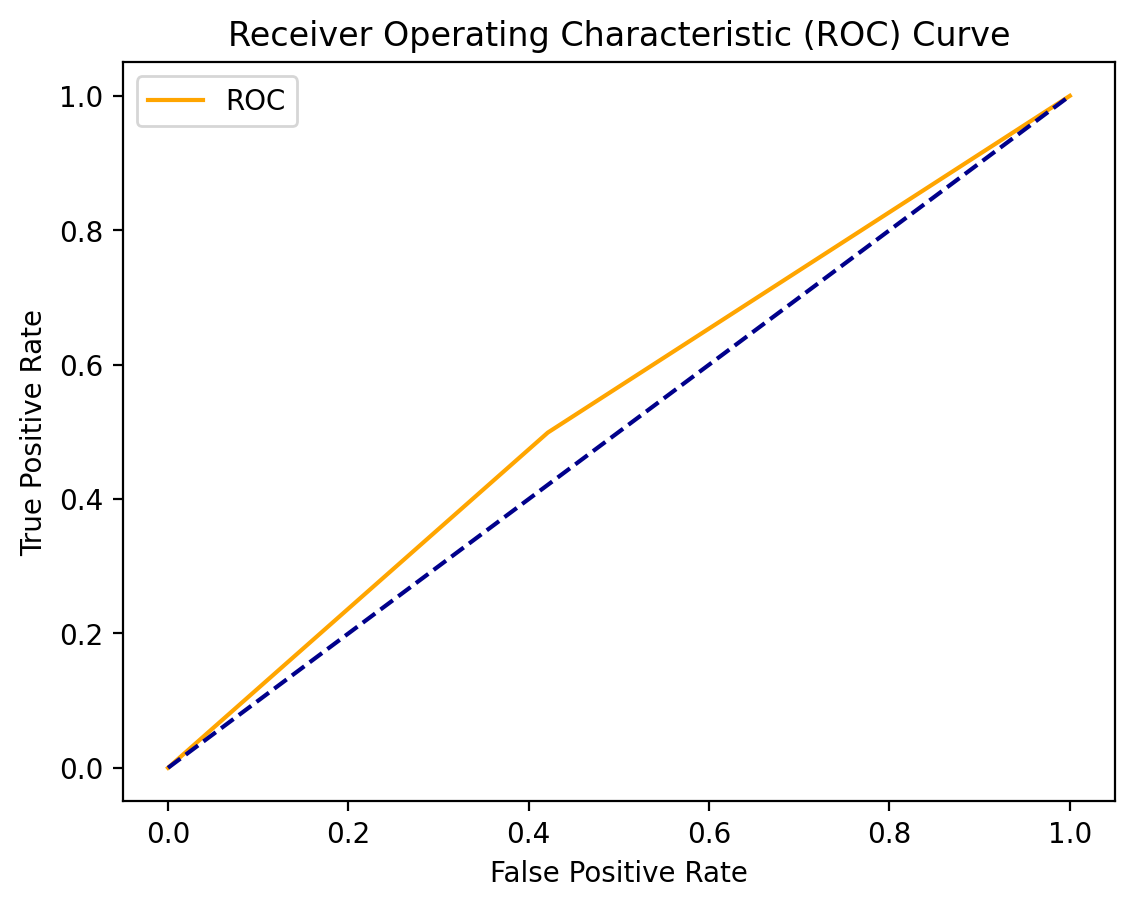

In [ ]:
## roc curve
auc_mod2 = roc_auc_score(y_test, y_pred_log)
print('AUC: %f' %auc_mod2)

fpr, tpr, _ = roc_curve(y_test, y_pred_log)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Naive Bayes 

In [ ]:
## create our naive bayes gaussian model 
gaussian_model = GaussianNB()
## train our model 
gaussian_model.fit(x_train,y_train)

GaussianNB()

In [ ]:
## make prediction 
y_pred_nb = gaussian_model.predict(x_test)

In [ ]:
## get the result in a dataframe 
result = {"Actual_fraud":y_test, "Predicted_fraud": y_pred_nb}
result_df = pd.DataFrame(result)
result_df

,Actual_fraud,Predicted_fraud
0,0,0
1,1,0
2,0,0
3,1,0
4,0,0
...,...,...
2541758,0,0
2541759,1,0
2541760,1,0
2541761,0,0


In [ ]:
## evaluate the model accuracy
accuracy_NB = accuracy_score(y_test, y_pred_nb)

## CONFUSION MATRIX
conf_mat = confusion_matrix(y_test, y_pred_nb)

print(accuracy_LR)
print(conf_mat)

0.5388917062684444
[[1271046       0]
 [1268171    2546]]


In [ ]:
## classification report
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67   1271046
           1       1.00      0.00      0.00   1270717

    accuracy                           0.50   2541763
   macro avg       0.75      0.50      0.34   2541763
weighted avg       0.75      0.50      0.34   2541763



AUC: 0.501002


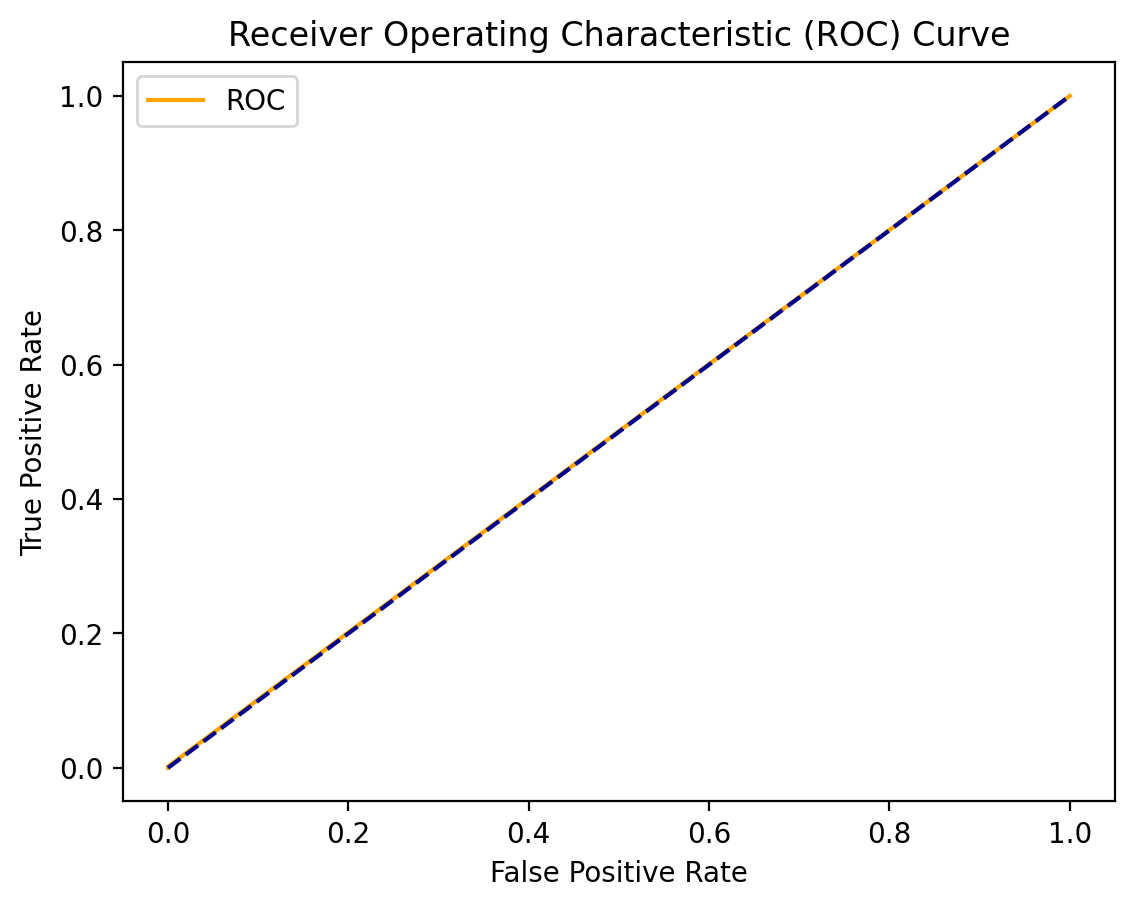

In [ ]:
## roc curve
auc_mod2 = roc_auc_score(y_test, y_pred_nb)
print('AUC: %f' %auc_mod2)

fpr, tpr, _ = roc_curve(y_test, y_pred_nb)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### K-Nearest Neighbours 

In [ ]:
## fit our knn model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train, y_train)

NameError: name 'KNeighborsClassifier' is not defined

In [ ]:
## make prediction
y_pred_knn = knn_model.predict(x_test)

In [ ]:
## evaluate the model accuracy
accuracy_NB = accuracy_score(y_test, y_pred_knn)

## CONFUSION MATRIX
conf_mat = confusion_matrix(y_test, y_pred_knn)

print(accuracy_LR)
print(conf_mat)

In [ ]:
## confusion matrix plot
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_mat, figsize=(2,2), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize = 18)
plt.ylabel('Actuals', fontsize = 18)
plt.title('confusion matrix', fontsize = 18)
plt.show()

In [ ]:
## classification report
print(classification_report(y_test, y_pred_knn))

In [ ]:
## roc curve
auc_mod2 = roc_auc_score(y_test, y_pred_knn)
print('AUC: %f' %auc_mod2)

fpr, tpr, _ = roc_curve(y_test, y_pred_knn)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Decision trees

In [ ]:
## decision tree model
decisiontree_gini = DecisionTreeClassifier()
## use max depth
decisiontree_depth = DecisionTreeClassifier(max_depth=3)
##use entropy criterion
decisiontree_entropy =DecisionTreeClassifier(criterion='entropy')

NameError: name 'DecisionTreeClassifier' is not defined

In [ ]:
## fit the trees
decisiontree_gini.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
decisiontree_entropy.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [ ]:
decisiontree_depth.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [ ]:
## make prediction
y_pred_gini = decisiontree_gini.predict(x_test)

In [ ]:
y_pred_entropy = decisiontree_entropy.predict(x_test)

In [ ]:
y_pred_depth = decisiontree_depth.predict(x_test)

In [1]:
print('Accuracy (gini): %.2f', metrics.accuracy_score(y_test, y_pred_gini))
print('Accuracy (enthropy):', metrics.accuracy_score(y_test, y_pred_entropy))
print('Accuracy (maxdepth):', metrics.accuracy_score(y_test, y_pred_depth))

NameError: name 'metrics' is not defined

In [ ]:
## classification report
print(classification_report(y_test, y_pred_gini))

              precision    recall  f1-score   support

           0       1.00      0.57      0.72   1271046
           1       0.70      1.00      0.82   1270717

    accuracy                           0.78   2541763
   macro avg       0.85      0.78      0.77   2541763
weighted avg       0.85      0.78      0.77   2541763



AUC: 0.782697


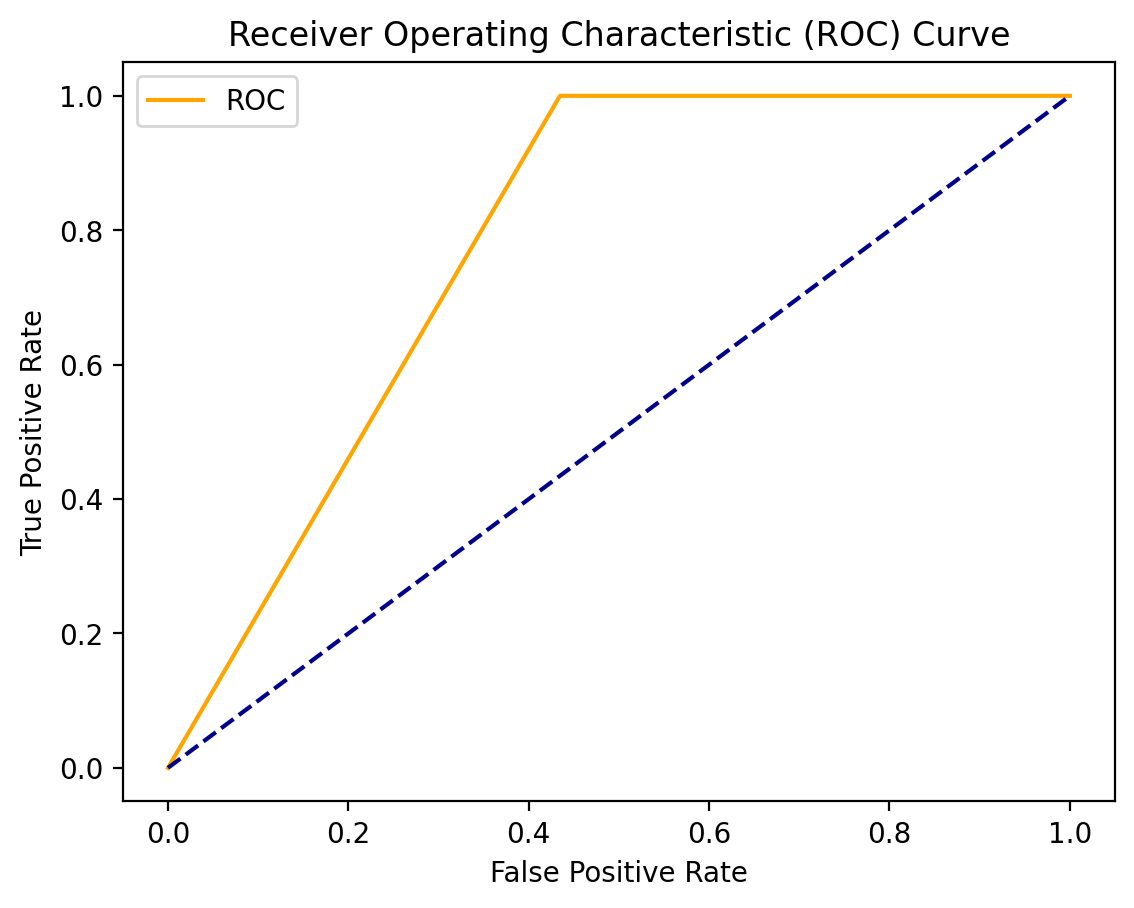

In [ ]:
## roc curve
auc_mod2 = roc_auc_score(y_test, y_pred_gini)
print('AUC: %f' %auc_mod2)

fpr, tpr, _ = roc_curve(y_test, y_pred_gini)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
## classification report
print(classification_report(y_test, y_pred_entropy))

              precision    recall  f1-score   support

           0       1.00      0.57      0.72   1271046
           1       0.70      1.00      0.82   1270717

    accuracy                           0.78   2541763
   macro avg       0.85      0.78      0.77   2541763
weighted avg       0.85      0.78      0.77   2541763



AUC: 0.782697


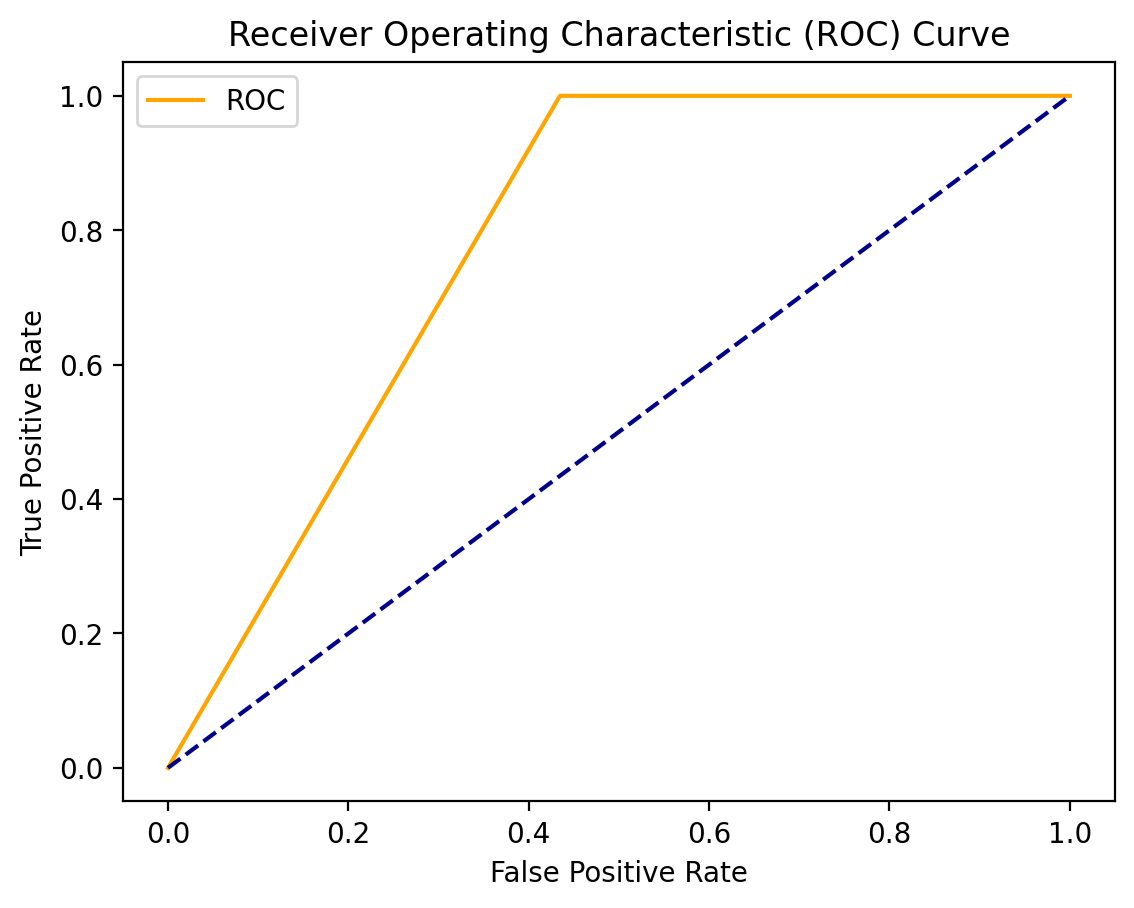

In [ ]:
## roc curve
auc_mod2 = roc_auc_score(y_test, y_pred_entropy)
print('AUC: %f' %auc_mod2)

fpr, tpr, _ = roc_curve(y_test, y_pred_entropy)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
## classification report
print(classification_report(y_test, y_pred_depth))

              precision    recall  f1-score   support

           0       0.65      0.92      0.76   1271046
           1       0.86      0.50      0.63   1270717

    accuracy                           0.71   2541763
   macro avg       0.75      0.71      0.69   2541763
weighted avg       0.75      0.71      0.69   2541763



AUC: 0.707729


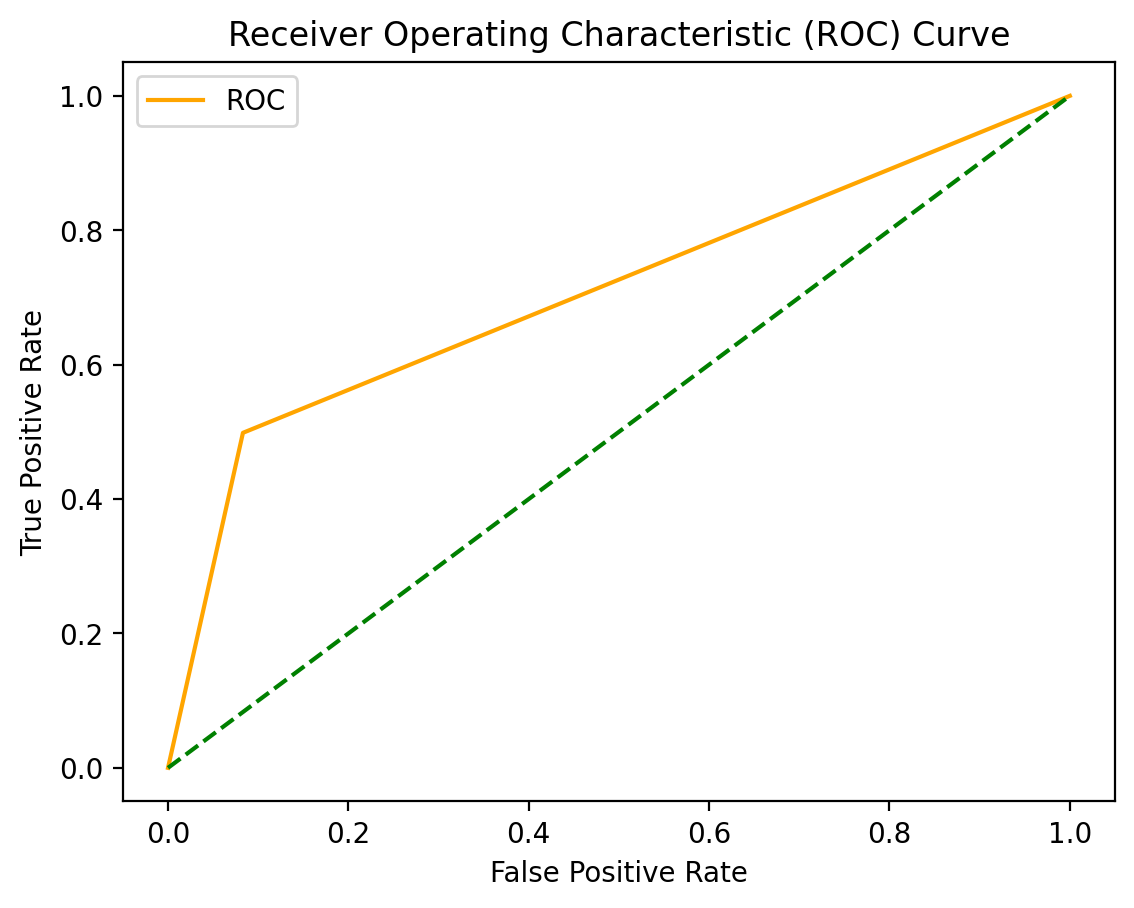

In [ ]:
## roc curve
auc_mod2 = roc_auc_score(y_test, y_pred_depth)
print('AUC: %f' %auc_mod2)

fpr, tpr, _ = roc_curve(y_test, y_pred_depth)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### SVM

In [ ]:
## create an object for svm
clfLinear = svm.SVC(kernel='linear')
clfsigmoid = svm.SVC(kernel='sigmoid')
clfrbf = svm.SVC(kernel='rbf')

In [ ]:
## train the model 
clfLinear.fit(x_train, y_train)
clfsigmoid.fit(x_train, y_train)
clfrbf.fit(x_train, y_train)

In [ ]:
## make prediction
y_pred_linear = clfLinear.predict(x_test)
y_pred_sigmoid = clfsigmoid.predict(x_test)
y_pred_rbf = clfrbf.predict(x_test)

In [ ]:
## model accuracy
print('Accuracy (linear):', metrics.accuracy_score(y_test, y_pred_linear))
print('Accuracy (sigmoid):', metrics.accuracy_score(y_test, y_pred_sigmoid))
print('Accuracy (rbf):', metrics.accuracy_score(y_test, y_pred_rbf))


In [ ]:
## classification report
print(classification_report(y_test, y_pred_linear))

In [ ]:
## classification report
print(classification_report(y_test, y_pred_sigmoid))

In [ ]:
## classification report
print(classification_report(y_test, y_pred_rbf))

ANN